In [ ]:
!pip install rarfile
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import pandas as pd
from itertools import combinations
from collections import Counter
import os
from google.colab import drive
from rarfile import RarFile
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn import metrics
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from torch.nn.functional import softmax
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to your RAR file in Google Drive
rar_path = '/content/drive/MyDrive/news_data.rar'  # Update this path
extract_path = '/content/news_extracted'  # Temporary extraction folder

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the RAR file
try:
    with RarFile(rar_path) as rf:
        # Find the first CSV file in the archive
        csv_files = [f for f in rf.namelist() if f.lower().endswith('.csv')]

        if not csv_files:
            raise FileNotFoundError("No CSV files found in the RAR archive")

        # Extract the first CSV file found
        csv_filename = csv_files[0]
        rf.extract(csv_filename, path=extract_path)

        # Full path to the extracted CSV
        extracted_csv_path = os.path.join(extract_path, csv_filename)

        # Load the CSV into a pandas DataFrame
        df_news = pd.read_csv(extracted_csv_path)

        print(f"Successfully extracted and loaded: {csv_filename}")
        print(f"DataFrame shape: {df_news.shape}")

        # Display first few rows
        print("\nFirst few rows:")
        print(df_news.head())

except Exception as e:
    print(f"Error: {str(e)}")
finally:
    # Clean up - remove extracted files
    if os.path.exists(extract_path):
        for file in os.listdir(extract_path):
            os.remove(os.path.join(extract_path, file))
        os.rmdir(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted and loaded: news_20250225to20250510.csv
DataFrame shape: (241650, 12)

First few rows:
                         ID           releasedAt  \
0  67bf0e677abefca47e66327d  2025-02-25 00:00:00   
1  67bf0e677abefca47e66327e  2025-02-25 00:00:00   
2  67bf0e677abefca47e66327f  2025-02-25 00:00:00   
3  67bf0e677abefca47e663280  2025-02-25 00:00:00   
4  67bf0e677abefca47e663281  2025-02-25 00:00:00   

                                               title  \
0  Traders are Elevating Their Portfolio with LIS...   
1  2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
2  Top Cryptos to Buy Now: The Best Choices for 2025   
3  Explore The Best Crypto Presale to Buy Now wit...   
4  ITI Launches Master’s in Trading Program for A...   

                                            subtitle         sourceName  \
0  The digital asset space sees cons

# FinBert Analysis

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load FinBERT model
model_name3 = "yiyanghkust/finbert-tone"
tokenizer3 = AutoTokenizer.from_pretrained(model_name3)
model3 = AutoModelForSequenceClassification.from_pretrained(model_name3)
model3.to(device)

def analyze_sentiment(texts):
    """
    Analyzes sentiment of a list of financial texts using FinBERT.
    Returns DataFrame with text and sentiment probabilities.
    """
    sentiments = []
    none_index = []
    for idx, text in enumerate(tqdm(texts, desc="Analyzing finance news"), start=0):
        if text is None:
            none_index.append(idx)
            continue
            sentiments.append({
                "text": None,
                "positive": None,
                "neutral": None,
                "negative": None,
                "raw_impact": None,
                "adjusted_impact": None})
        inputs = tokenizer3(text,
            return_tensors="pt",
            truncation=True,        # Important
            max_length=512,         # Limit input length
            padding=True).to(device)
        with torch.no_grad():
            outputs = model3(**inputs)
            probs = softmax(outputs.logits, dim=1).squeeze().cpu().numpy()

        positive, neutral, negative = probs
        raw_score = positive - negative
        adjusted_score = raw_score * (1 - neutral)

        sentiment = {
            "text": text,
            "positive": positive,
            "neutral": neutral,
            "negative": negative,
            "raw_impact": raw_score,
            "adjusted_impact": adjusted_score
        }
        sentiments.append(sentiment)
    return pd.DataFrame(sentiments), none_index

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
# Load the fine-tuned crypto sentiment model
model_name2 = "Robertuus/Crypto_Sentiment_Analysis_Bert"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2)
model2.to(device)

# Sentiment labels
labels = ['positive', 'negative']

# Sentiment analysis function
def analyze_crypto_news(news_list):
    results = []
    none_index = []
    for idx, text in enumerate(tqdm(news_list, desc="Analyzing Crypto news"), start=0):
        if text is None:
            none_index.append(idx)
            continue
            sentiments.append({
                "text": None,
                "positive": None,
                "neutral": None,
                "negative": None,
                "raw_impact": None,
                "adjusted_impact": None})
        inputs = tokenizer2(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model2(**inputs)
            probs = softmax(outputs.logits, dim=1).detach().cpu().numpy().flatten()

        sentiment = {
            "text": text,
            "positive": float(probs[0]),
            "negative": float(probs[1]),
            "predicted_label": labels[int(probs.argmax())],
            "impact": float(probs[0]) - float(probs[1])
        }
        results.append(sentiment)
    return pd.DataFrame(results), none_index

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
btc_news = df_news[df_news['asset_symbols'].str.contains(r'\bBTC\b', case=False, na=False)]
btc_news

ID           releasedAt  \
1       67bf0e677abefca47e66327e  2025-02-25 00:00:00   
5       67bf0e677abefca47e663282  2025-02-25 00:00:00   
22      67bf0e5b7abefca47e663270  2025-02-25 00:33:22   
24      67bf0e5b7abefca47e66326e  2025-02-25 00:35:51   
25      67bf0e5b7abefca47e66326d  2025-02-25 00:38:14   
...                          ...                  ...   
241636  681f2b652f35612ca7364559  2025-05-10 10:28:45   
241640  681f2df764fa9d1327a5ad34  2025-05-10 10:35:00   
241641  681f2df764fa9d1327a5ad33  2025-05-10 10:35:15   
241645  681f2df764fa9d1327a5ad2f  2025-05-10 10:38:58   
241648  681f2f61944b463d4d8a67f4  2025-05-10 10:42:16   

                                                    title  \
1       2025’s Crypto Battle: Altcoin vs. XRP and Bitc...   
5       Bitcoin Dives Below $90K Amid ETF Sell-Offs an...   
22      Montana Bitcoin reserve fund voted down, makin...   
24      Changpeng Zhao Shares His Crypto Portfolio: A ...   
25              What Does Zhao’s Crypto Portfolio Reveal?   
...                                                   ...   
241636     US VP Vance to Address Bitcoin 2025 Conference   
241640  Coinbase Reveals Cautious Approach, Avoids Bit...   
241641  Conor McGregor Advocates for Ireland's Bitcoin...   
241645  Bitcoin & Ethereum $3 Billion Options Set to E...   
241648  Steak ‘n Shake Embraces Bitcoin for Nationwide...   

                                                 subtitle         sourceName  \
1       Digital currencies now play a key role in glob...  Crypto Front News   
5       Bitcoin has dropped below $90,000 for the firs...     WalletInvestor   
22      A proposal in the Montana House of Representat...      Cryptopolitan   
24      Changpeng Zhao has shared his crypto portfolio...      COINTURK NEWS   
25      Changpeng Zhao, the prominent figure behind Bi...            BH NEWS   
...                                                   ...                ...   
241636  US VP JD Vance will speak at Bitcoin 2025, mar...         CoinLineup   
241640  Coinbase rejected a high-risk Bitcoin strategy...     CryptoNewsLand   
241641  Conor McGregor calls for Ireland Bitcoin reser...         TheCCPress   
241645  Bitcoin and Ethereum options worth $3 billion ...        CoinLive.me   
241648  Steak ‘n Shake will accept Bitcoin payments at...      COINTURK NEWS   

                                                sourceUrl         source  \
1       https://coinmarketcap.com/community/en/article...  coinmarketcap   
5       https://coinmarketcap.com/community/en/article...  coinmarketcap   
22      https://coinmarketcap.com/community/en/article...  coinmarketcap   
24      https://coinmarketcap.com/community/en/article...  coinmarketcap   
25      https://coinmarketcap.com/community/en/article...  coinmarketcap   
...                                                   ...            ...   
241636  https://coinmarketcap.com/community/en/article...  coinmarketcap   
241640  https://cryptonewsland.com/coinbase-reveals-ca...  coinmarketcap   
241641  https://coinmarketcap.com/community/en/article...  coinmarketcap   
241645  https://coinmarketcap.com/community/en/article...  coinmarketcap   
241648  https://coinmarketcap.com/community/en/article...  coinmarketcap   

                                                     slug  \
1       blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...   
5       bitcoin-dives-below-90k-amid-etf-sell-offs-and...   
22      montana-bitcoin-reserve-fund-voted-down-making...   
24      changpeng-zhao-shares-his-crypto-portfolio-a-b...   
25                what-does-zhaos-crypto-portfolio-reveal   
...                                                   ...   
241636                   us-vp-vance-bitcoin-2025-address   
241640  coinbase-reveals-cautious-approach-avoids-bitc...   
241641             conor-mcgregor-ireland-bitcoin-reserve   
241645           bitcoin-ethereum-options-expire-may-2025   
241648  steak-n-shake-embraces-bitcoin-for-nationwide-...   

     

In [ ]:
# Apply to BTC news (assume df is already filtered as `btc_news`)
content_sent, none_content = analyze_sentiment(btc_news['content'].tolist())
title_sent, none_title = analyze_sentiment(btc_news['title'].tolist())
subtitle_sent, none_subtitle = analyze_sentiment(btc_news['subtitle'].fillna("").tolist())

# Rename columns for clarity
content_sent = content_sent.add_prefix("content_")
title_sent = title_sent.add_prefix("title_")
subtitle_sent = subtitle_sent.add_prefix("subtitle_")

# Combine all into one DataFrame
btc_sentiment = pd.concat([btc_news.reset_index(drop=True), content_sent, title_sent, subtitle_sent], axis=1)


Analyzing finance news:   0%|          | 0/18114 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Analyzing finance news:   0%|          | 0/18114 [00:00<?, ?it/s]

Analyzing finance news:   0%|          | 0/18114 [00:00<?, ?it/s]

In [ ]:
# Apply to BTC news (assume df is already filtered as `btc_news`)
content_sent, none_content = analyze_crypto_news(btc_news['content'].tolist())
title_sent, none_title = analyze_crypto_news(btc_news['title'].tolist())
subtitle_sent, none_subtitle = analyze_crypto_news(btc_news['subtitle'].fillna("").tolist())

# Rename columns for clarity
content_sent = content_sent.add_prefix("content_")
title_sent = title_sent.add_prefix("title_")
subtitle_sent = subtitle_sent.add_prefix("subtitle_")

# Combine all into one DataFrame
btc_crypto_sentiment = pd.concat([btc_news.reset_index(drop=True), content_sent, title_sent, subtitle_sent], axis=1)


Analyzing Crypto news:   0%|          | 0/18114 [00:00<?, ?it/s]

Analyzing Crypto news:   0%|          | 0/18114 [00:00<?, ?it/s]

Analyzing Crypto news:   0%|          | 0/18114 [00:00<?, ?it/s]

# Use Scores for Prediction

In [ ]:
drive.mount('/content/drive')

# 2) Point to wherever you stored the pickle
path = '/content/drive/MyDrive/data_btc_1min.pickle'
df_ohlcv = pd.read_pickle(path)
df_ohlcv.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dateTime       open       high        low      close  \
0 2025-02-01 00:00:00  102429.56  102431.38  102333.00  102333.01   
1 2025-02-01 00:01:00  102333.01  102360.02  102328.29  102340.67   
2 2025-02-01 00:02:00  102340.67  102363.51  102319.00  102319.01   
3 2025-02-01 00:03:00  102319.01  102330.00  102300.00  102300.01   
4 2025-02-01 00:04:00  102300.00  102319.23  102274.50  102318.00   

        volume               closeTime  quoteAssetVolume  numberOfTrades  \
0  13.95242000 2025-02-01 00:00:59.999  1428274.95948110            3208   
1   6.13914000 2025-02-01 00:01:59.999   628315.57433470            1939   
2   3.69962000 2025-02-01 00:02:59.999   378614.96583750            1778   
3   4.94628000 2025-02-01 00:03:59.999   506099.53088330            1411   
4   5.83550000 2025-02-01 00:04:59.999   596938.78673800            3296   

  takerBuyBaseVol takerBuyQuoteVol ignore  
0      2.41966000  247693.80458960      0  
1      3.99198000  408551.32104090      0  
2      1.53574000  157173.86438010      0  
3      1.89116000  193501.33556970      0  
4      4.09921000  419328.96693330      0

# Prediction Correlation and Test

In [ ]:
def find_plot_most_accuracy_correlation(horizons, sentiment_df, df_ohlcv, impact_col_name, impact_name):
    ohlcv = df_ohlcv.copy()
    ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
    ohlcv = ohlcv.sort_values('dateTime')

    return_dict = {
        f'return_{h}m': ohlcv['close'].shift(-h) / ohlcv['close'] - 1
        for h in horizons
    }

    returns_df = pd.DataFrame(return_dict, index=ohlcv.index)
    ohlcv = pd.concat([ohlcv, returns_df], axis=1)

    sent = sentiment_df.copy()
    sent['releasedAt'] = pd.to_datetime(sent['releasedAt'])
    sent = sent.sort_values('releasedAt')
    sent = sent.rename(columns={impact_col_name: 'impact'})

    correlations = []
    accuracies   = []

    for h in tqdm(horizons, desc="Evaluating horizons"):
        ret_col = f'return_{h}m'

        merged = pd.merge_asof(
            sent,
            ohlcv[['dateTime', ret_col]],
            left_on='releasedAt',
            right_on='dateTime',
            direction='forward',
            tolerance=pd.Timedelta('1min')
        ).dropna(subset=[ret_col])

        # pearson correlation
        corr = merged['impact'].corr(merged[ret_col])
        correlations.append(corr)

        # classification accuracy
        actual_up = merged[ret_col] > 0
        pred_up   = merged['impact'] > 0
        accuracies.append(accuracy_score(actual_up, pred_up))

        metrics_df = pd.DataFrame({
        'horizon_min':   horizons,
        'horizon_hr':    horizons / 60,
        'correlation':   correlations,
        'accuracy':      accuracies
    })

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(metrics_df['horizon_hr'], metrics_df['correlation'], label='Correlation', linewidth=2)
    ax2.plot(metrics_df['horizon_hr'], metrics_df['accuracy'],   label='Accuracy',   linestyle='--', linewidth=2)
    ax1.set_xlabel('Horizon (hours)')
    ax1.set_ylabel('Pearson Correlation')
    ax2.set_ylabel('Classification Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.title("Sentiment Impact of " + impact_name + " vs. Future Returns Over Horizons")
    plt.show()

    # — 6) Print best-performing horizons
    best_corr = metrics_df.loc[metrics_df['correlation'].idxmax()]
    best_acc  = metrics_df.loc[metrics_df['accuracy'].idxmax()]

    print(f"Highest correlation at {int(best_corr['horizon_min'])} min ({best_corr['horizon_hr']:.1f} h): {best_corr['correlation']:.4f}")
    print(f"Highest accuracy    at {int(best_acc['horizon_min'])} min ({best_acc['horizon_hr']:.1f} h): {best_acc['accuracy']:.4f}")


In [ ]:
horizons = np.arange(10, 10000, 10)

# FinBert Model Prediction Test

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

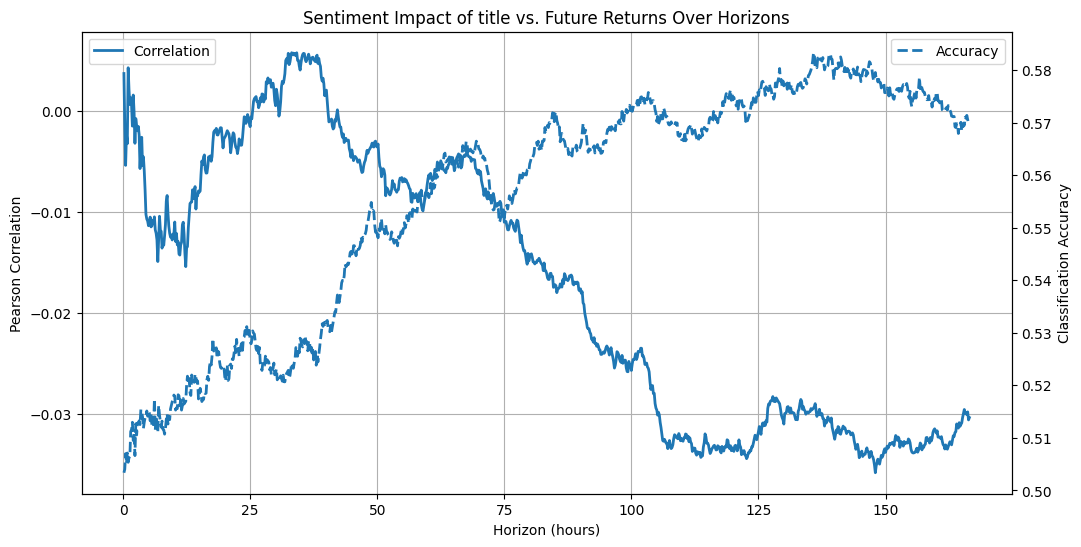

Highest correlation at 1990 min (33.2 h): 0.0057
Highest accuracy    at 8150 min (135.8 h): 0.5833


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_sentiment, df_ohlcv, "title_raw_impact", "title")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

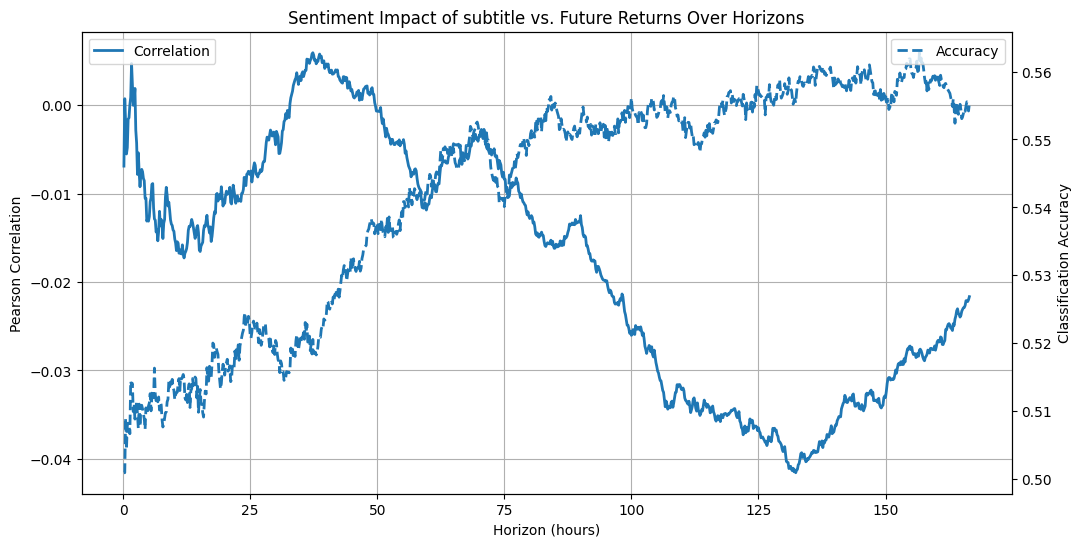

Highest correlation at 2240 min (37.3 h): 0.0059
Highest accuracy    at 9400 min (156.7 h): 0.5628


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_sentiment, df_ohlcv, "subtitle_raw_impact", "subtitle")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

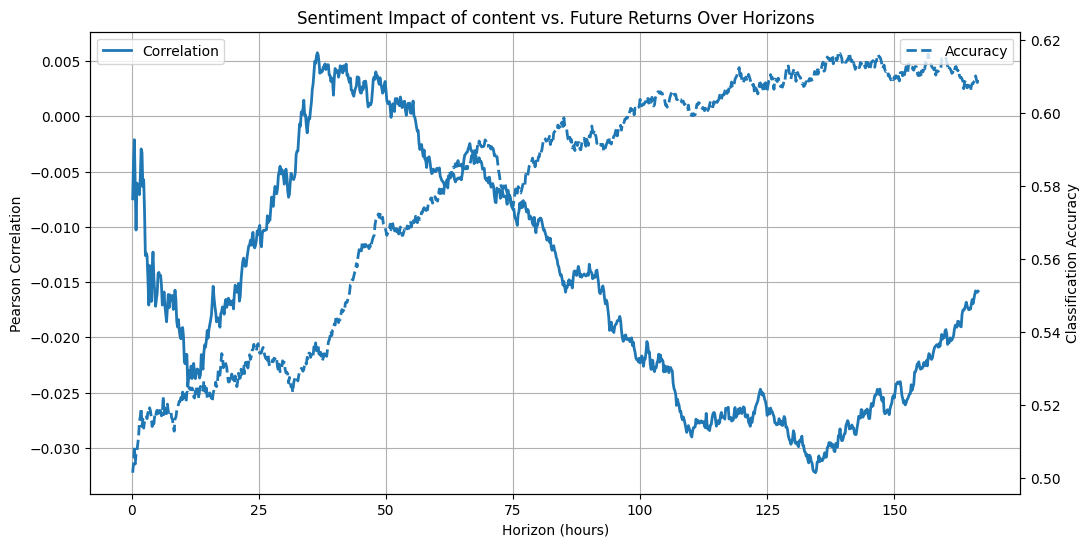

Highest correlation at 2190 min (36.5 h): 0.0057
Highest accuracy    at 8340 min (139.0 h): 0.6164


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_sentiment, df_ohlcv, "content_raw_impact", "content")

# Crypto Bert Model Prediction Test

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

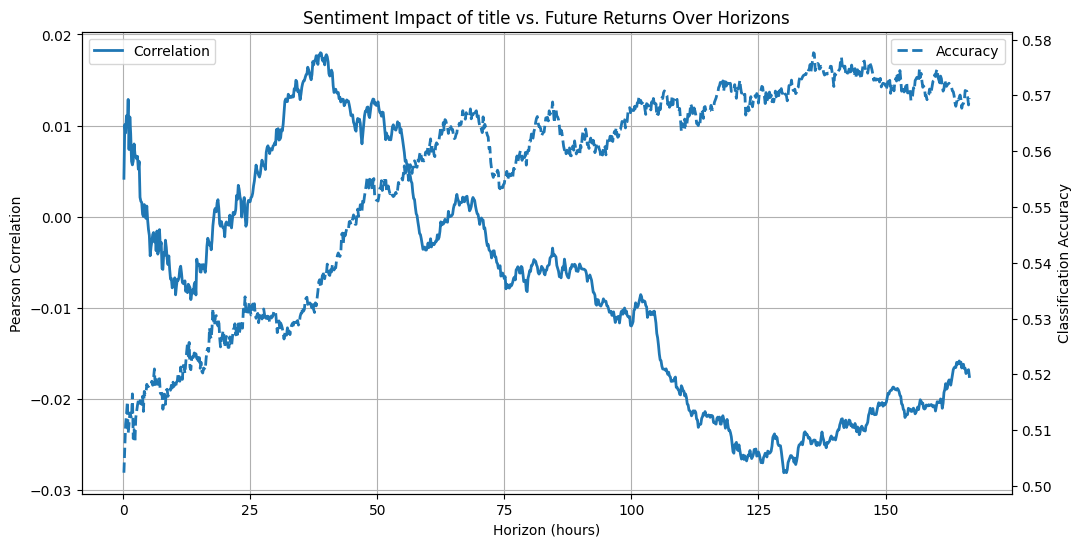

Highest correlation at 2330 min (38.8 h): 0.0180
Highest accuracy    at 8150 min (135.8 h): 0.5776


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_crypto_sentiment, df_ohlcv, "title_impact" , "title")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

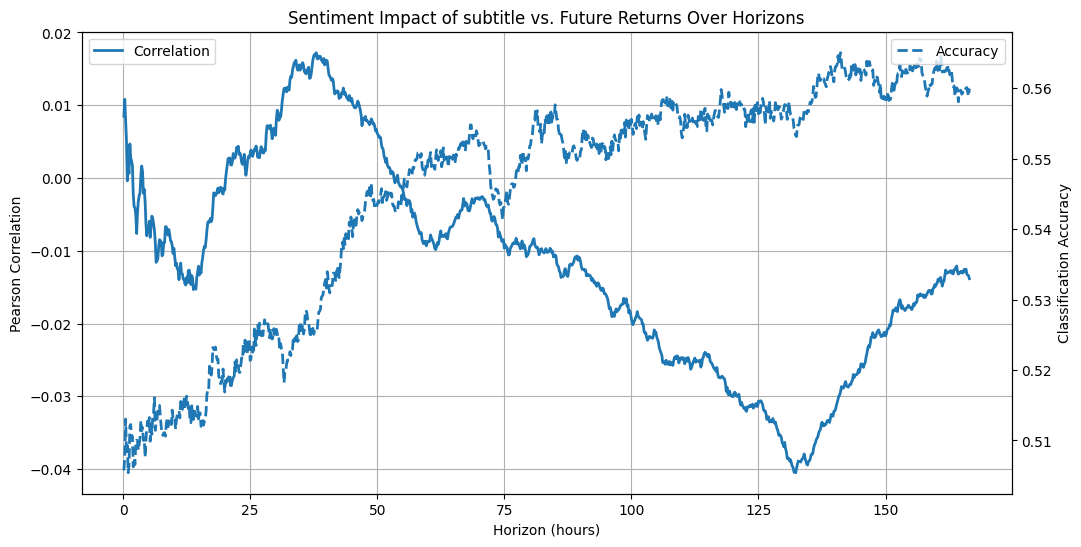

Highest correlation at 2280 min (38.0 h): 0.0172
Highest accuracy    at 8470 min (141.2 h): 0.5650


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_crypto_sentiment, df_ohlcv, "subtitle_impact", "subtitle")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

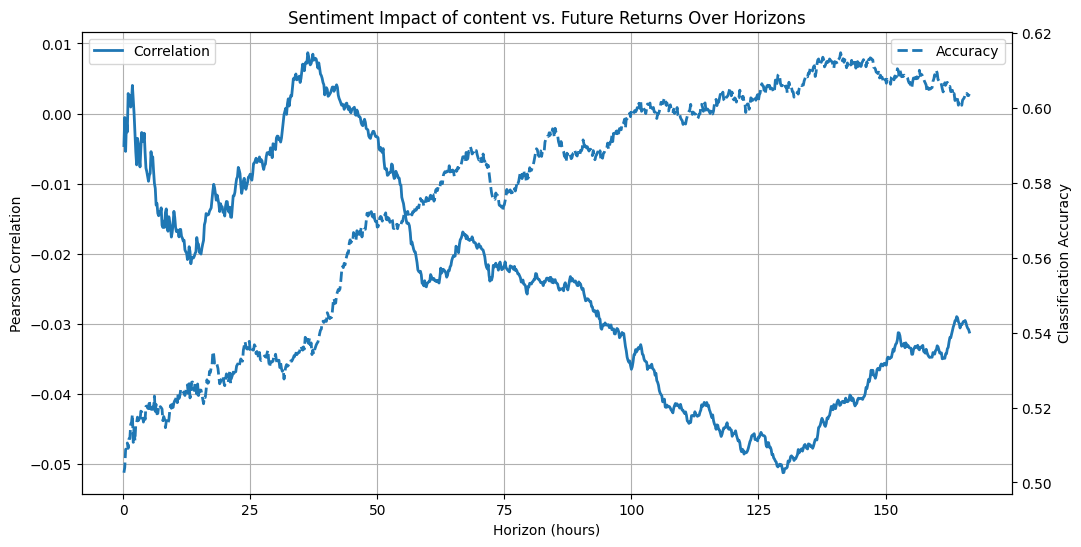

Highest correlation at 2180 min (36.3 h): 0.0087
Highest accuracy    at 8470 min (141.2 h): 0.6148


In [ ]:
find_plot_most_accuracy_correlation(horizons, btc_crypto_sentiment, df_ohlcv, "content_impact", "content")

In [ ]:
btc_crypto_sentiment['source'].unique()

array(['coinmarketcap', 'tradingview-stock', 'tradingview-crypto',
       'tradingview-etf'], dtype=object)

In [ ]:
top20_sources = btc_crypto_sentiment['sourceName'] \
    .value_counts() \
    .head(20) \
    .index \
    .tolist()

top20_sources

['Bitcoin Sistemi',
 'BitcoinWorld',
 'COINTURK NEWS',
 'BH NEWS',
 'CryptoNewsLand',
 'Cointelegraph.com News',
 'Crypto Front News',
 'crypto.news',
 'CoinPedia News',
 'Bitcoin Info News',
 'CoinoMedia',
 'Coincu',
 'Kanal Coin',
 'TheCCPress',
 'Coindoo',
 'The Crypto Times',
 'Cryptopolitan',
 'CryptoPotato',
 'CoinDesk',
 'Cointribune']

In [ ]:
for source in top20_sources:
    print(source + " bitcoin news count: " + str(len(btc_crypto_sentiment[btc_crypto_sentiment['sourceName'] == source])))

Bitcoin Sistemi bitcoin news count: 1676
BitcoinWorld bitcoin news count: 1042
COINTURK NEWS bitcoin news count: 1001
BH NEWS bitcoin news count: 999
CryptoNewsLand bitcoin news count: 991
Cointelegraph.com News bitcoin news count: 860
Crypto Front News bitcoin news count: 842
crypto.news bitcoin news count: 765
CoinPedia News bitcoin news count: 691
Bitcoin Info News bitcoin news count: 569
CoinoMedia bitcoin news count: 556
Coincu bitcoin news count: 540
Kanal Coin bitcoin news count: 497
TheCCPress bitcoin news count: 497
Coindoo bitcoin news count: 425
The Crypto Times bitcoin news count: 389
Cryptopolitan bitcoin news count: 360
CryptoPotato bitcoin news count: 354
CoinDesk bitcoin news count: 293
Cointribune bitcoin news count: 293


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

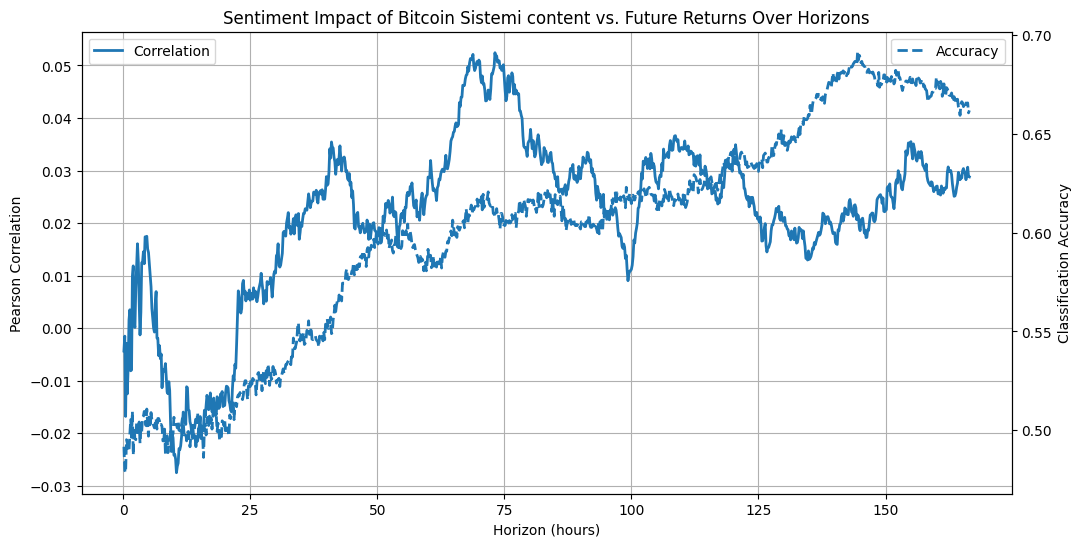

Highest correlation at 4390 min (73.2 h): 0.0524
Highest accuracy    at 8670 min (144.5 h): 0.6910


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

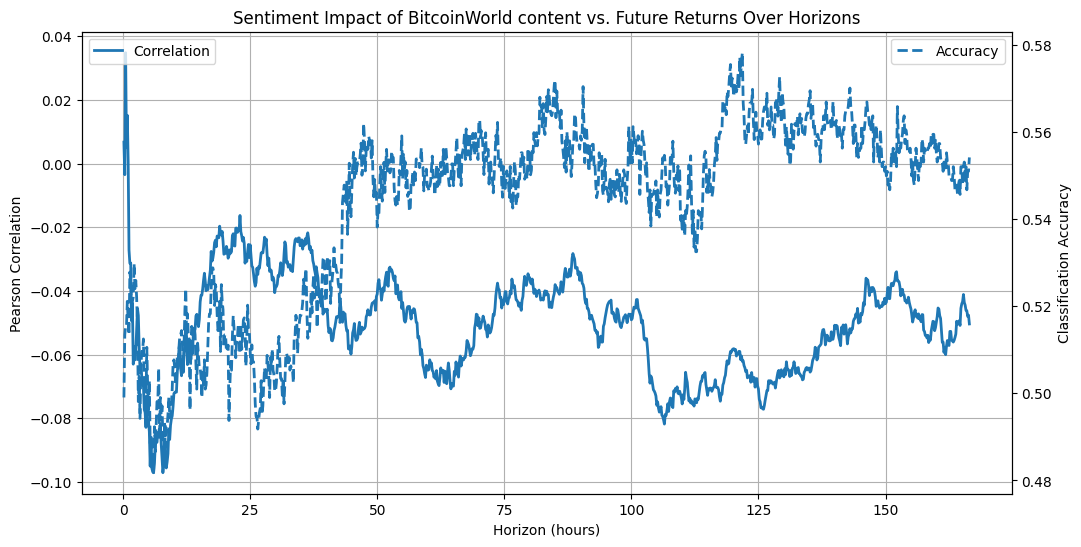

Highest correlation at 30 min (0.5 h): 0.0348
Highest accuracy    at 7310 min (121.8 h): 0.5782


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

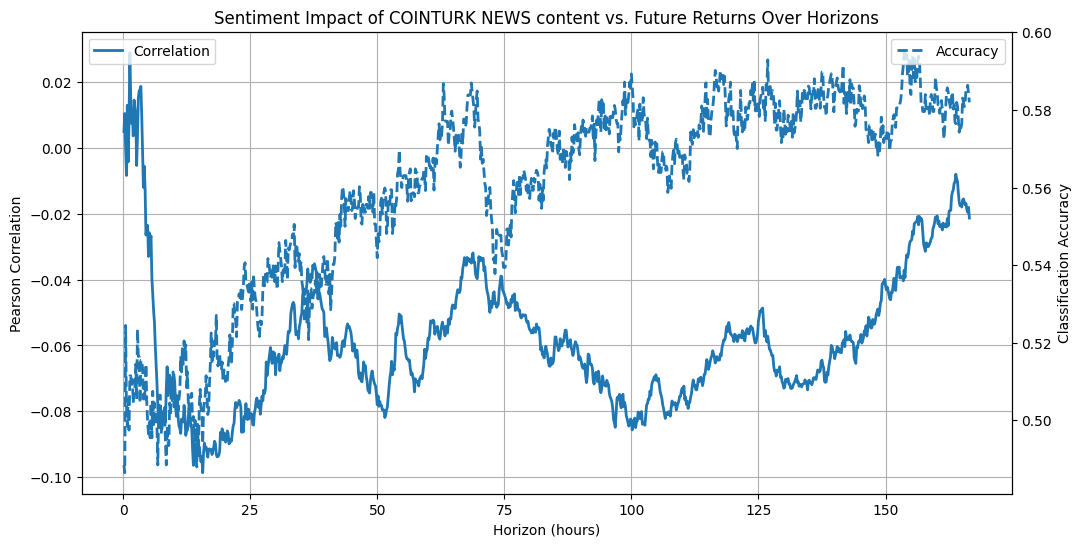

Highest correlation at 80 min (1.3 h): 0.0290
Highest accuracy    at 9220 min (153.7 h): 0.5947


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

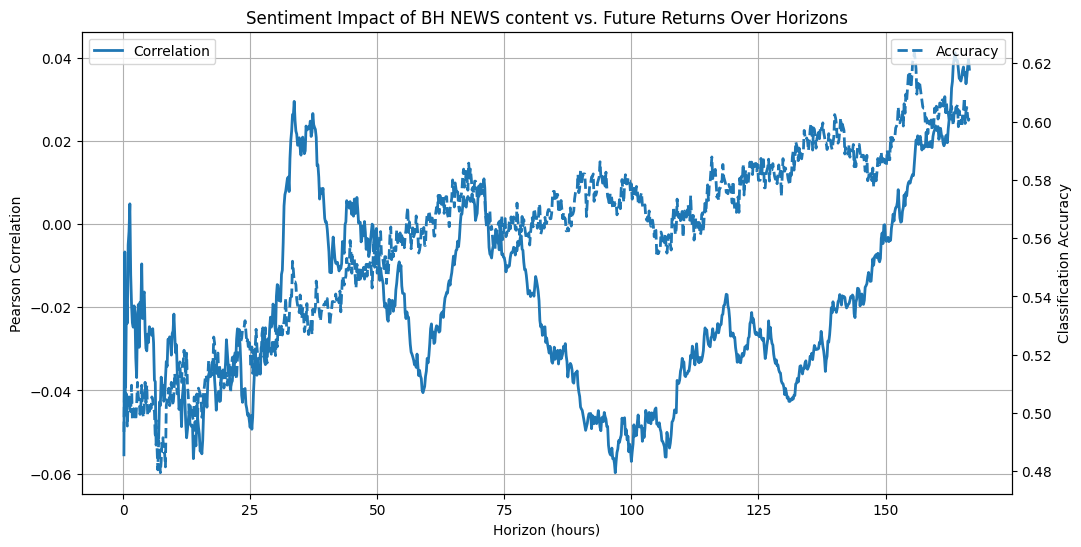

Highest correlation at 9820 min (163.7 h): 0.0412
Highest accuracy    at 9340 min (155.7 h): 0.6236


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

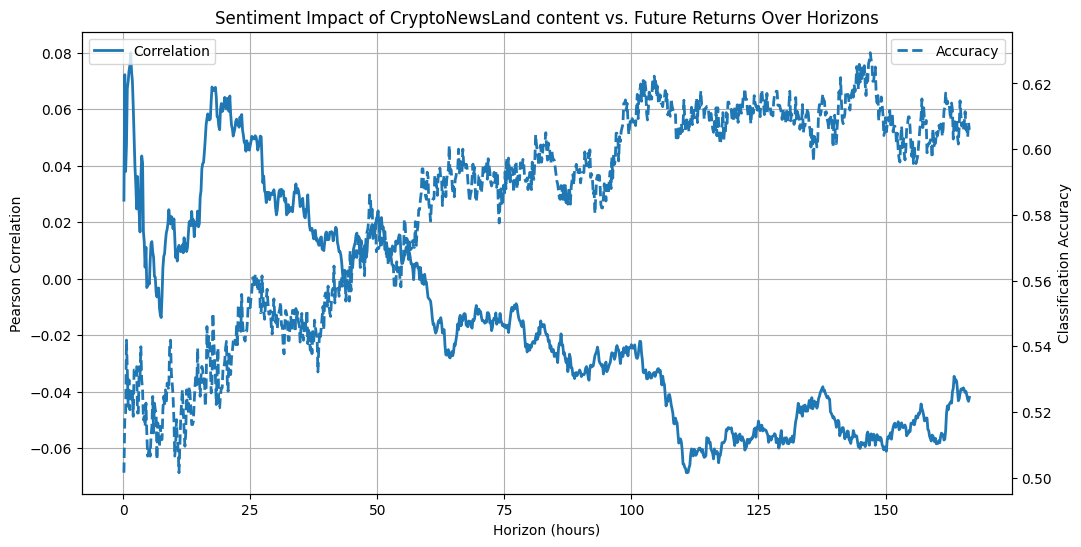

Highest correlation at 90 min (1.5 h): 0.0801
Highest accuracy    at 8820 min (147.0 h): 0.6293


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

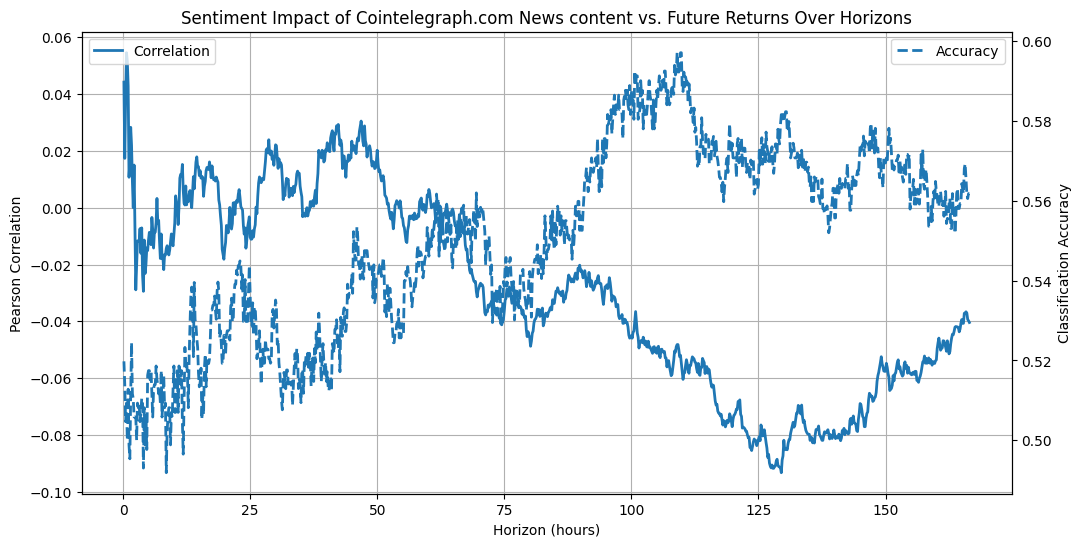

Highest correlation at 40 min (0.7 h): 0.0545
Highest accuracy    at 6540 min (109.0 h): 0.5971


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

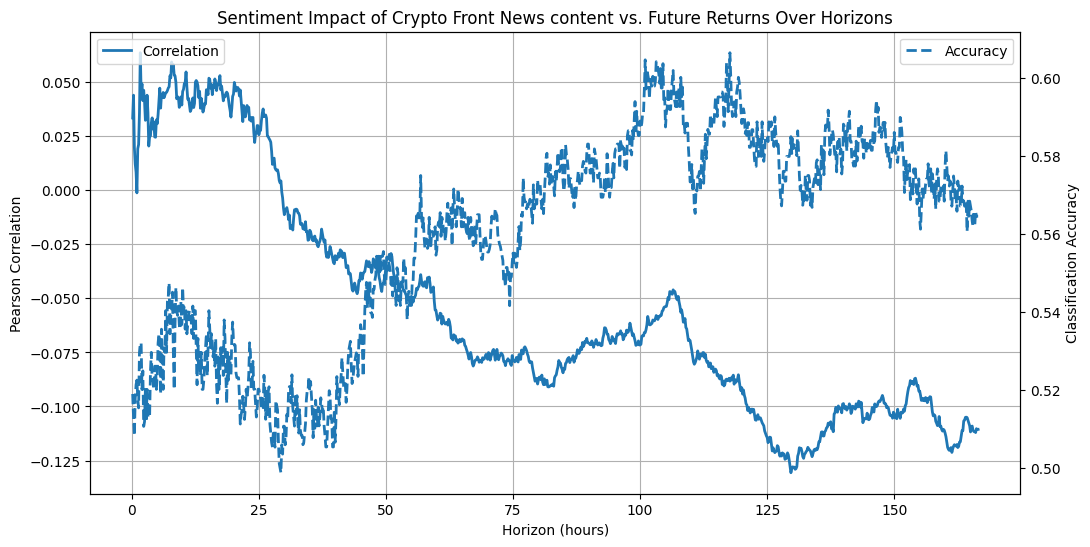

Highest correlation at 100 min (1.7 h): 0.0636
Highest accuracy    at 7060 min (117.7 h): 0.6066


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

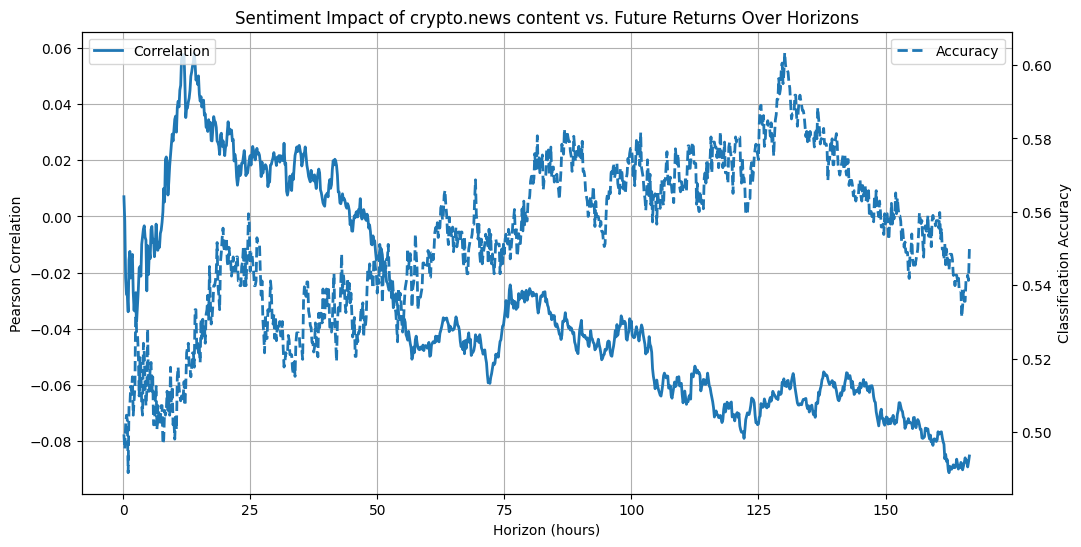

Highest correlation at 840 min (14.0 h): 0.0584
Highest accuracy    at 7810 min (130.2 h): 0.6034


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

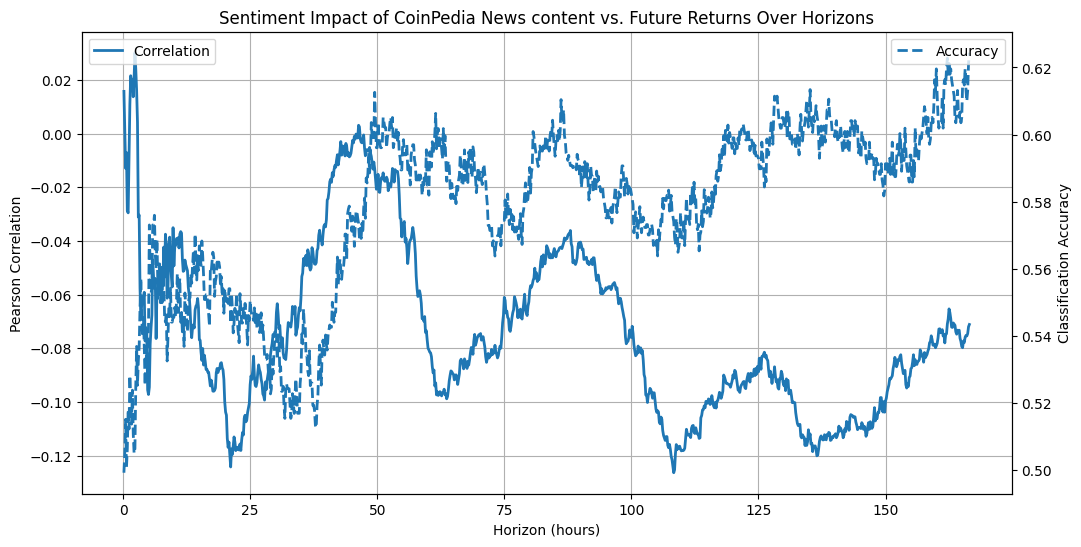

Highest correlation at 140 min (2.3 h): 0.0301
Highest accuracy    at 9990 min (166.5 h): 0.6244


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

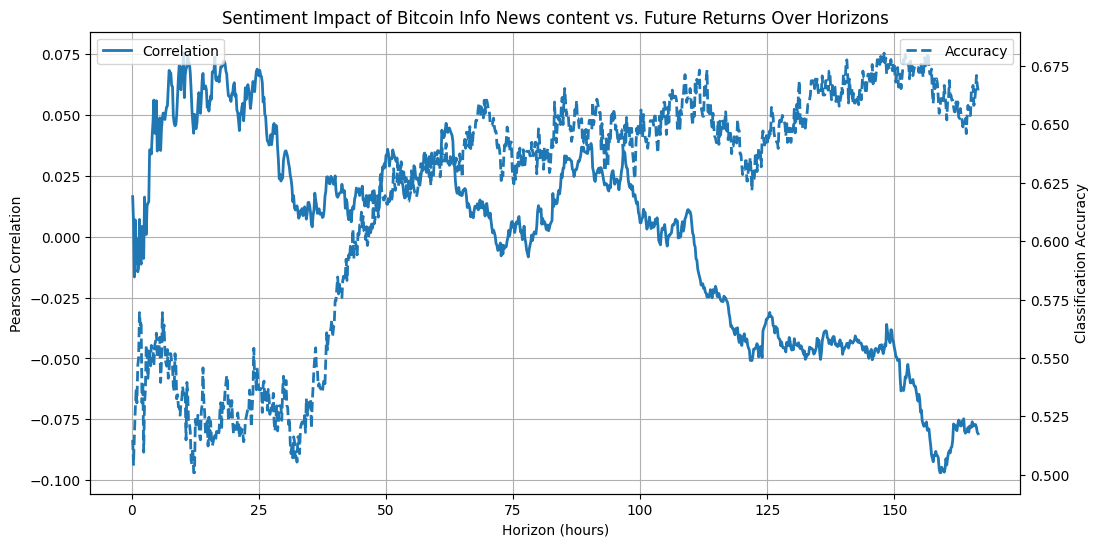

Highest correlation at 610 min (10.2 h): 0.0756
Highest accuracy    at 9400 min (156.7 h): 0.6807


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

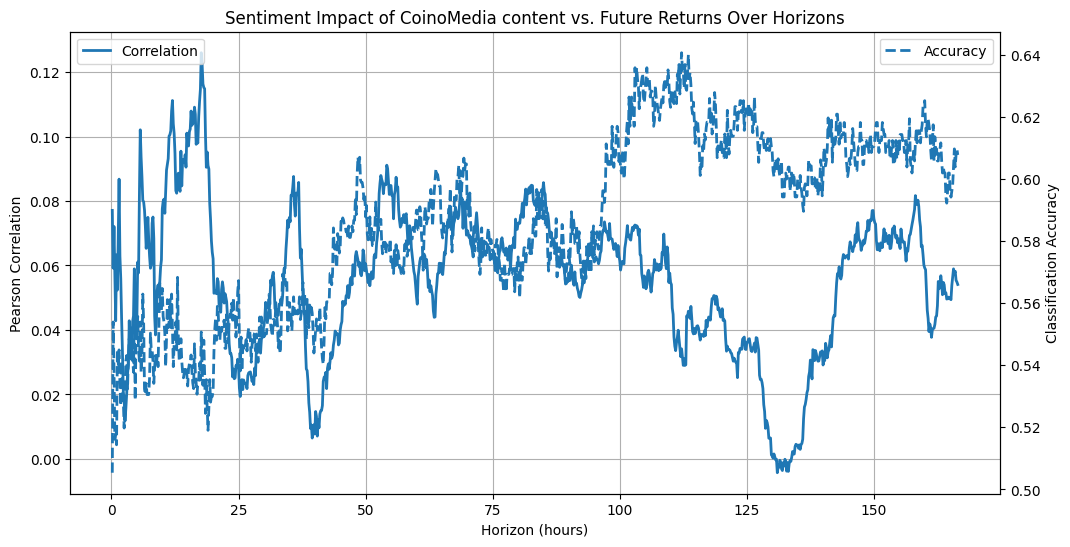

Highest correlation at 1060 min (17.7 h): 0.1260
Highest accuracy    at 6730 min (112.2 h): 0.6407


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

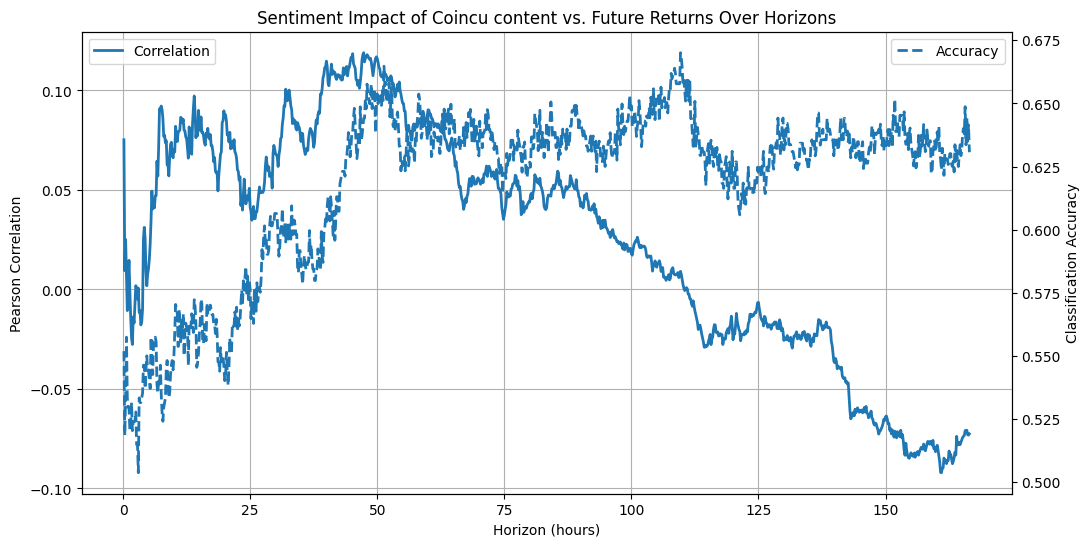

Highest correlation at 2840 min (47.3 h): 0.1190
Highest accuracy    at 6580 min (109.7 h): 0.6701


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

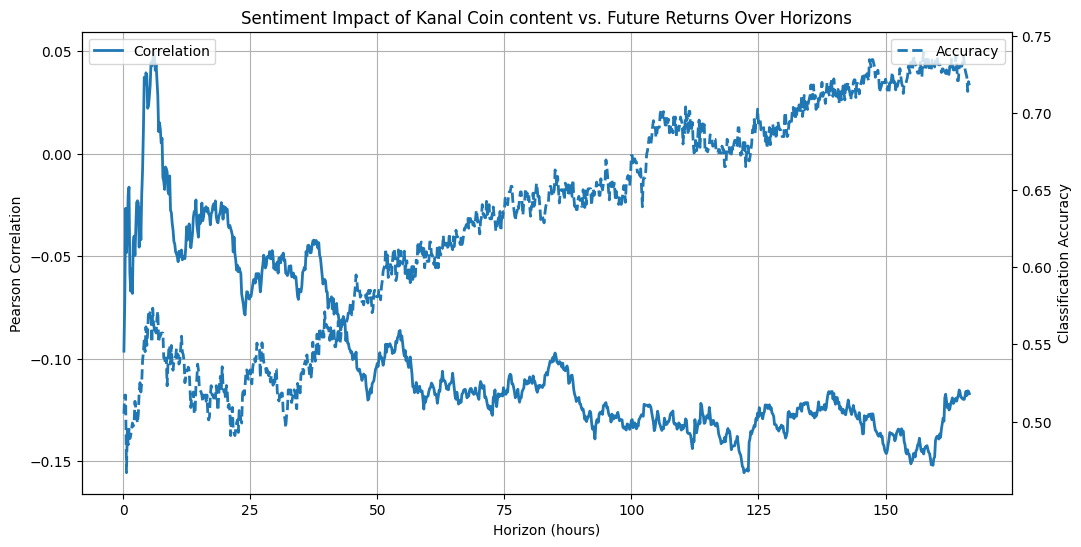

Highest correlation at 360 min (6.0 h): 0.0493
Highest accuracy    at 9450 min (157.5 h): 0.7390


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

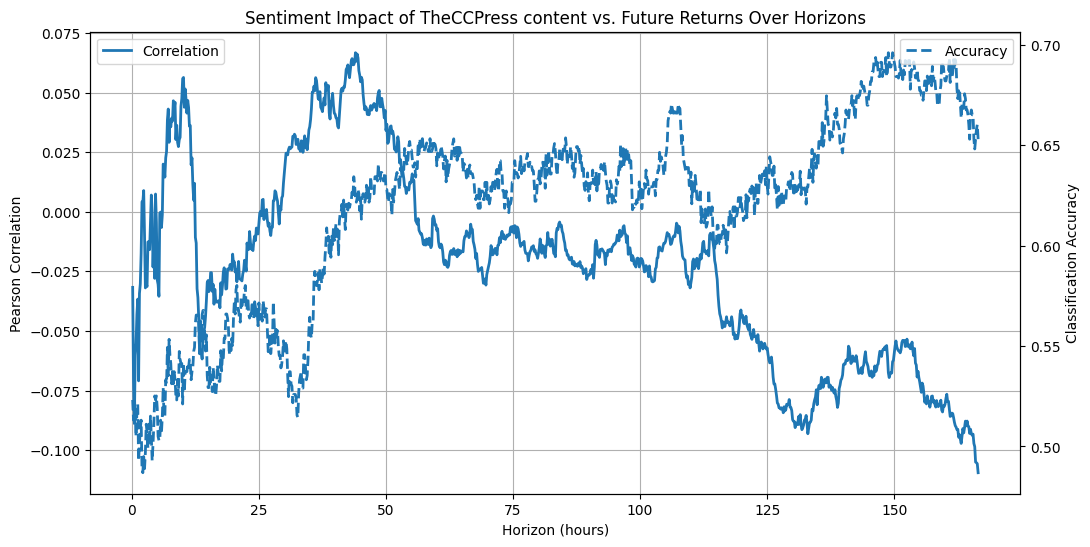

Highest correlation at 2640 min (44.0 h): 0.0667
Highest accuracy    at 8930 min (148.8 h): 0.6960


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

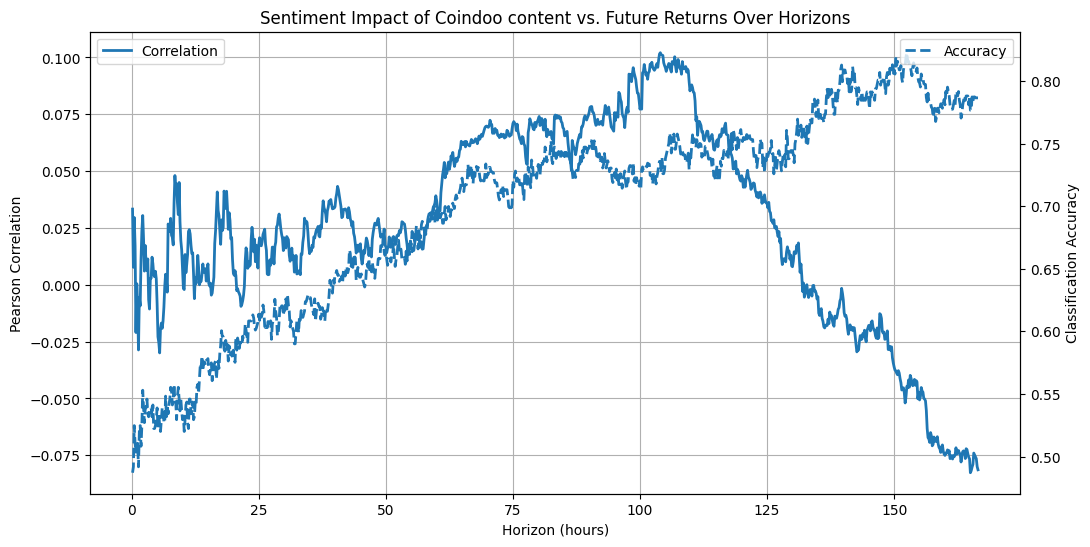

Highest correlation at 6240 min (104.0 h): 0.1021
Highest accuracy    at 9150 min (152.5 h): 0.8225


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

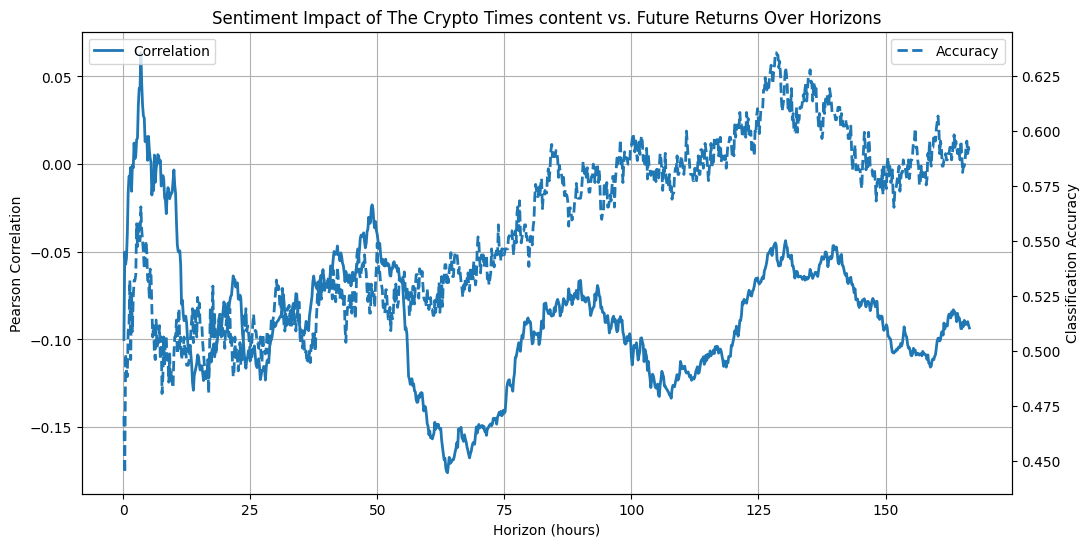

Highest correlation at 210 min (3.5 h): 0.0635
Highest accuracy    at 7700 min (128.3 h): 0.6356


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

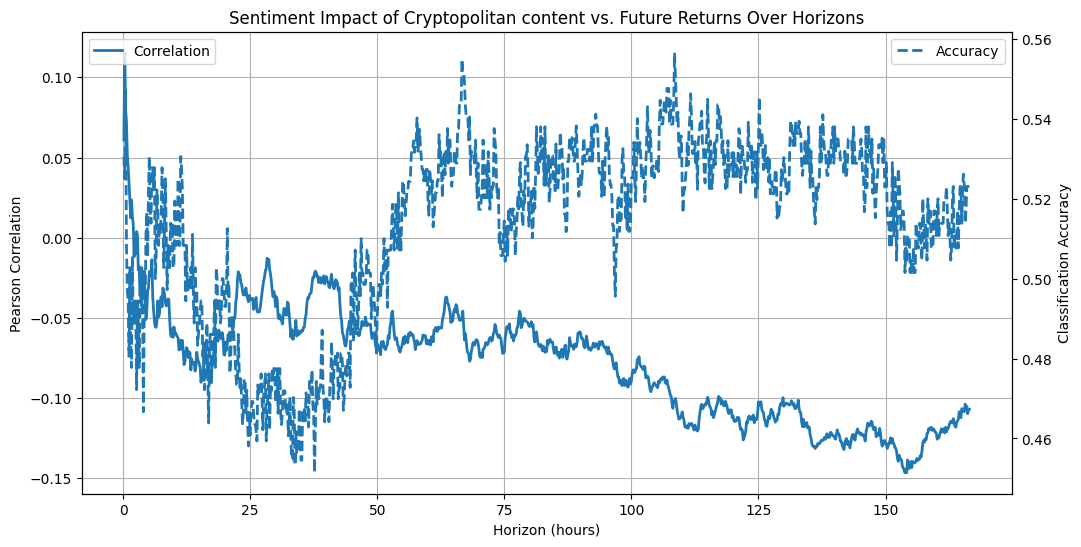

Highest correlation at 20 min (0.3 h): 0.1153
Highest accuracy    at 6510 min (108.5 h): 0.5565


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

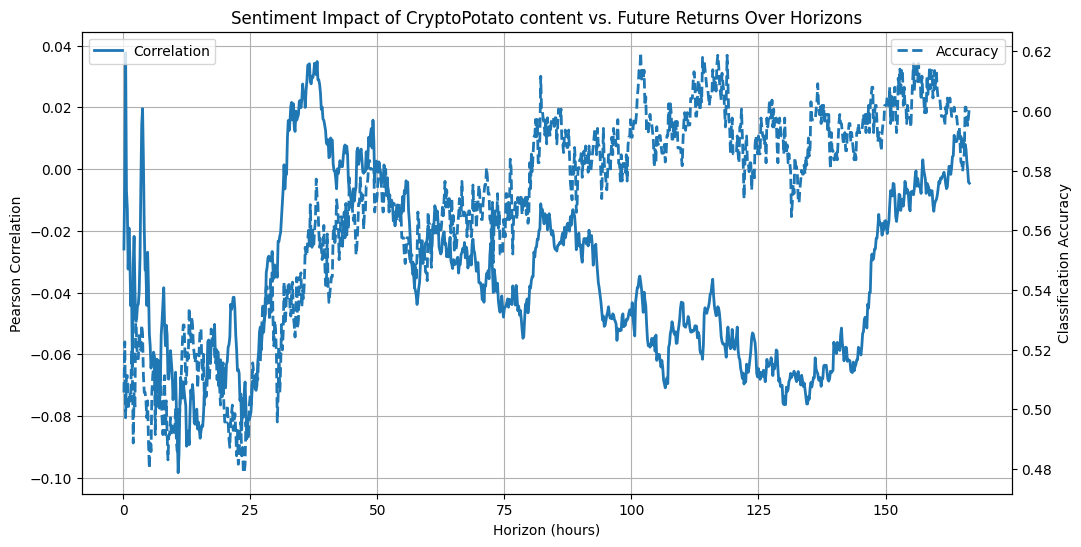

Highest correlation at 30 min (0.5 h): 0.0377
Highest accuracy    at 6110 min (101.8 h): 0.6195


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

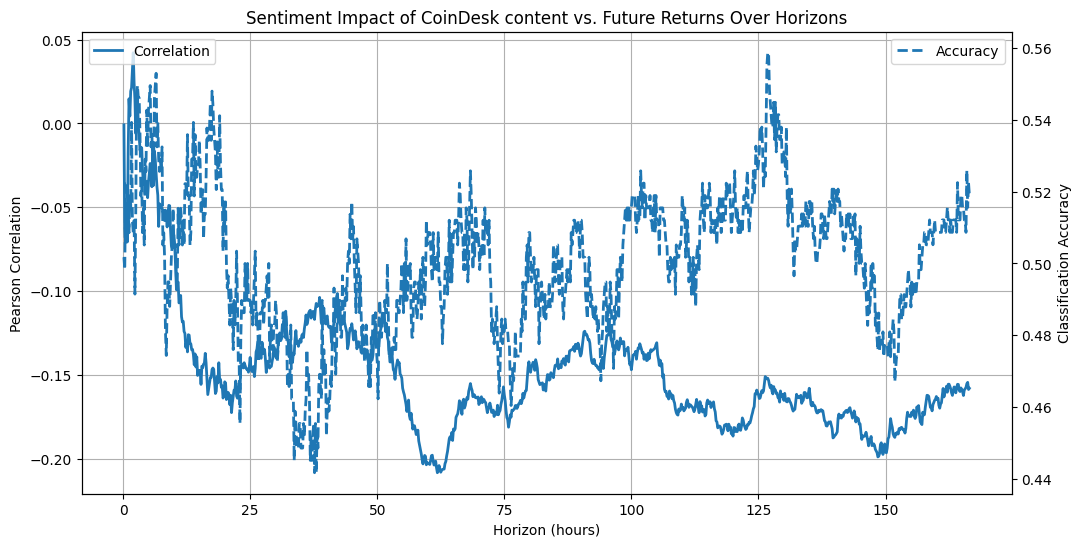

Highest correlation at 120 min (2.0 h): 0.0422
Highest accuracy    at 7610 min (126.8 h): 0.5586


Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

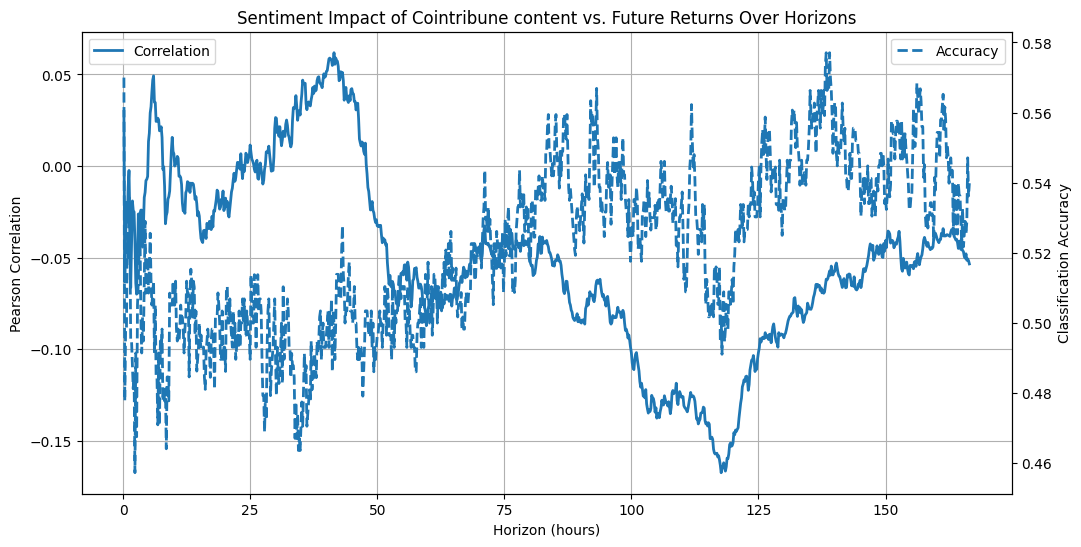

Highest correlation at 2490 min (41.5 h): 0.0618
Highest accuracy    at 8300 min (138.3 h): 0.5771


In [ ]:
for source in top20_sources:
    find_plot_most_accuracy_correlation(
        horizons,
        btc_crypto_sentiment[btc_crypto_sentiment['sourceName'] == source],
        df_ohlcv,
        "content_impact",
        source + " content")

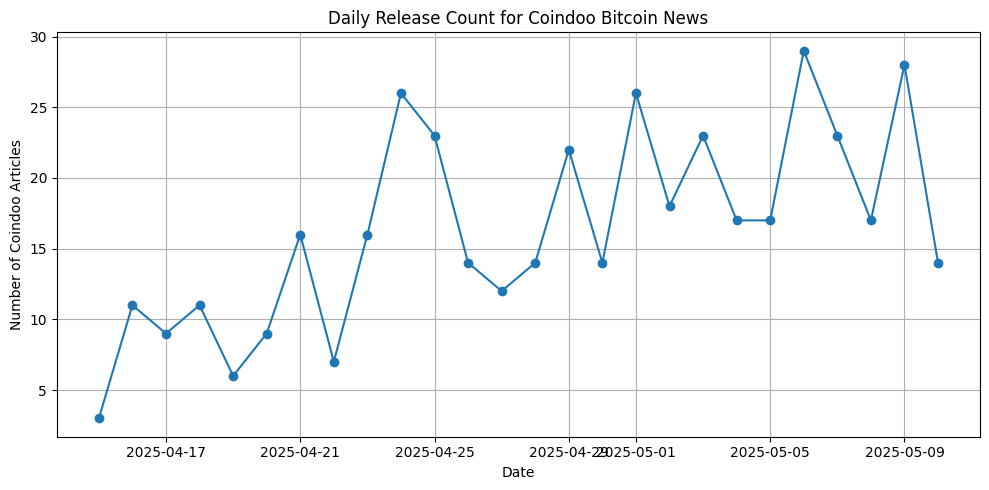

In [ ]:
# 1) Ensure releasedAt is datetime
btc_crypto_sentiment['releasedAt'] = pd.to_datetime(btc_crypto_sentiment['releasedAt'])

# 2) Filter for Coindoo
df_coindoo = btc_crypto_sentiment[
    btc_crypto_sentiment['sourceName'].str.contains('Coindoo', case=False)
].copy()

# 3) Aggregate counts by day (change freq='H' for hourly, or 'T' for minute-level)
daily_counts = (
    df_coindoo
    .set_index('releasedAt')
    .groupby(pd.Grouper(freq='D'))
    .size()
)

# 4) Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Coindoo Articles')
plt.title('Daily Release Count for Coindoo Bitcoin News')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def aggregate_sentiment_per_minute(sentiment_df, time_col, impact_col):
    """
    Groups sentiment_df by each minute (flooring timestamps) and
    returns a new DataFrame with:
      - minute: the floored datetime (to minute)
      - impact: the average impact of all items in that minute
    """
    df = sentiment_df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    # floor to the minute
    df['minute'] = df[time_col].dt.floor('min')
    # group and average
    agg = (
        df
        .groupby('minute')[impact_col]
        .mean()
        .reset_index()
        .rename(columns={'minute':'releasedAt', impact_col:'impact'})
    )
    return agg

def find_plot_metrics_by_minute(horizons, sentiment_df, df_ohlcv, impact_col_name, impact_name):
    # 1) Pre-aggregate sentiment into minute buckets
    sent_agg = aggregate_sentiment_per_minute(sentiment_df, time_col='releasedAt', impact_col=impact_col_name)
    sent_agg = sent_agg.sort_values('releasedAt')

    # 2) Prepare OHLCV
    ohlcv = df_ohlcv.copy()
    ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
    ohlcv = ohlcv.sort_values('dateTime')

    # 3) Compute all shifted returns at once (avoid fragmentation)
    return_dict = {
        f'return_{h}m': ohlcv['close'].shift(-h) / ohlcv['close'] - 1
        for h in horizons
    }
    returns_df = pd.DataFrame(return_dict, index=ohlcv.index)
    ohlcv = pd.concat([ohlcv, returns_df], axis=1)

    # 4) Loop to compute per-horizon metrics
    correlations = []
    accuracies   = []

    for h in tqdm(horizons, desc="Evaluating horizons"):
        ret_col = f'return_{h}m'

        # merge-on minute-to-minute basis
        merged = pd.merge_asof(
            sent_agg,
            ohlcv[['dateTime', ret_col]],
            left_on='releasedAt',
            right_on='dateTime',
            direction='forward',
            tolerance=pd.Timedelta('1min')
        ).dropna(subset=[ret_col])

        correlations.append( merged['impact'].corr(merged[ret_col]) )
        actual_up = merged[ret_col] > 0
        pred_up   = merged['impact'] > 0
        accuracies.append( accuracy_score(actual_up, pred_up) )

    # 5) Build metrics DataFrame & plot
    metrics_df = pd.DataFrame({
        'horizon_min': horizons,
        'horizon_hr':  horizons / 60,
        'correlation': correlations,
        'accuracy':    accuracies
    })

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(metrics_df['horizon_hr'], metrics_df['correlation'], label='Correlation', linewidth=2)
    ax2.plot(metrics_df['horizon_hr'], metrics_df['accuracy'],   label='Accuracy',   linestyle='--', linewidth=2)

    ax1.set_xlabel('Horizon (hours)')
    ax1.set_ylabel('Pearson Correlation')
    ax2.set_ylabel('Classification Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.title(f"Avg {impact_name} Impact vs. Future Returns Over Horizons")
    plt.show()

    # 6) Print best-performing horizons
    best_corr = metrics_df.loc[metrics_df['correlation'].idxmax()]
    best_acc  = metrics_df.loc[metrics_df['accuracy'].idxmax()]

    print(f"▶ Highest correlation at {int(best_corr['horizon_min'])} min "
          f"({best_corr['horizon_hr']:.1f} h): {best_corr['correlation']:.4f}")
    print(f"▶ Highest accuracy    at {int(best_acc['horizon_min'])} min "
          f"({best_acc['horizon_hr']:.1f} h): {best_acc['accuracy']:.4f}")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

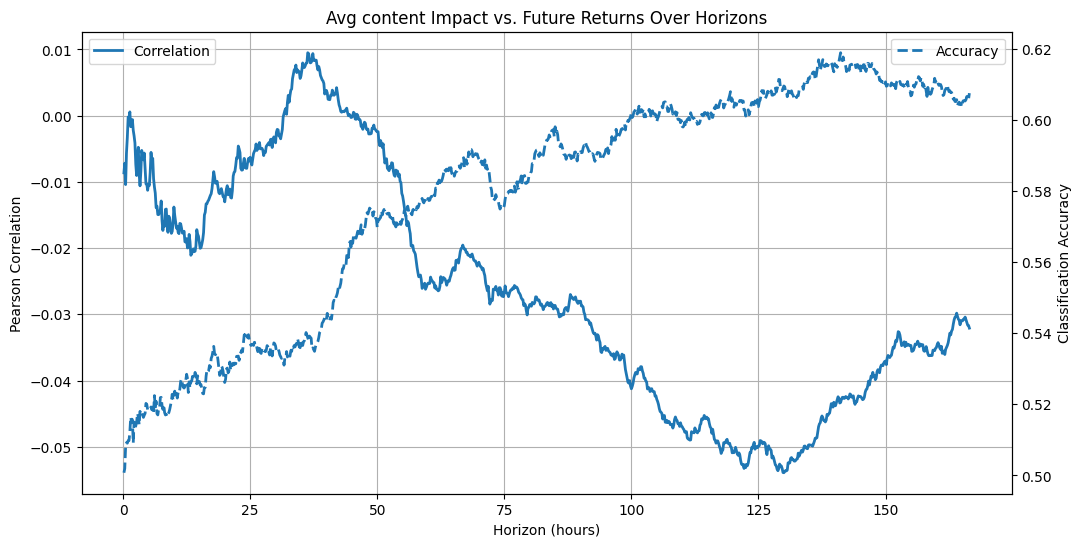

▶ Highest correlation at 2180 min (36.3 h): 0.0095
▶ Highest accuracy    at 8470 min (141.2 h): 0.6190


In [ ]:
# Example usage:
horizons = np.arange(10, 10000, 10)  # every 10m up to 2 days
find_plot_metrics_by_minute(
    horizons,
    sentiment_df=btc_crypto_sentiment,
    df_ohlcv=df_ohlcv,
    impact_col_name='content_impact',   # or 'content_impact', etc.
    impact_name='content'
)

In [ ]:
def aggregate_sentiment_per_hour(sentiment_df, time_col, impact_col):
    """
    Groups sentiment_df into hourly buckets (flooring timestamps to the hour)
    and returns a DataFrame with:
      - hour: the floored datetime (to the hour)
      - impact: the average impact of all items in that hour
    """
    df = sentiment_df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    # floor to the hour
    df['hour'] = df[time_col].dt.floor('h')
    # group and average
    agg = (
        df
        .groupby('hour')[impact_col]
        .mean()
        .reset_index()
        .rename(columns={'hour': time_col, impact_col: 'impact'})
    )
    return agg

def find_plot_metrics_by_hour(horizons, sentiment_df, df_ohlcv, impact_col_name, impact_name):
    # 1) Pre-aggregate sentiment into minute buckets
    sent_agg = aggregate_sentiment_per_hour(sentiment_df, time_col='releasedAt', impact_col=impact_col_name)
    sent_agg = sent_agg.sort_values('releasedAt')

    # 2) Prepare OHLCV
    ohlcv = df_ohlcv.copy()
    ohlcv['dateTime'] = pd.to_datetime(ohlcv['dateTime'])
    ohlcv = ohlcv.sort_values('dateTime')

    # 3) Compute all shifted returns at once (avoid fragmentation)
    return_dict = {
        f'return_{h}m': ohlcv['close'].shift(-h) / ohlcv['close'] - 1
        for h in horizons
    }
    returns_df = pd.DataFrame(return_dict, index=ohlcv.index)
    ohlcv = pd.concat([ohlcv, returns_df], axis=1)

    # 4) Loop to compute per-horizon metrics
    correlations = []
    accuracies   = []

    for h in tqdm(horizons, desc="Evaluating horizons"):
        ret_col = f'return_{h}m'

        # merge-on minute-to-minute basis
        merged = pd.merge_asof(
            sent_agg,
            ohlcv[['dateTime', ret_col]],
            left_on='releasedAt',
            right_on='dateTime',
            direction='forward',
            tolerance=pd.Timedelta('1min')
        ).dropna(subset=[ret_col])

        correlations.append( merged['impact'].corr(merged[ret_col]) )
        actual_up = merged[ret_col] > 0
        pred_up   = merged['impact'] > 0
        accuracies.append( accuracy_score(actual_up, pred_up) )

    # 5) Build metrics DataFrame & plot
    metrics_df = pd.DataFrame({
        'horizon_min': horizons,
        'horizon_hr':  horizons / 60,
        'correlation': correlations,
        'accuracy':    accuracies
    })

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    ax1.plot(metrics_df['horizon_hr'], metrics_df['correlation'], label='Correlation', linewidth=2)
    ax2.plot(metrics_df['horizon_hr'], metrics_df['accuracy'],   label='Accuracy',   linestyle='--', linewidth=2)

    ax1.set_xlabel('Horizon (hours)')
    ax1.set_ylabel('Pearson Correlation')
    ax2.set_ylabel('Classification Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.title(f"Avg {impact_name} Impact vs. Future Returns Over Horizons")
    plt.show()

    # 6) Print best-performing horizons
    best_corr = metrics_df.loc[metrics_df['correlation'].idxmax()]
    best_acc  = metrics_df.loc[metrics_df['accuracy'].idxmax()]

    print(f"▶ Highest correlation at {int(best_corr['horizon_min'])} min "
          f"({best_corr['horizon_hr']:.1f} h): {best_corr['correlation']:.4f}")
    print(f"▶ Highest accuracy    at {int(best_acc['horizon_min'])} min "
          f"({best_acc['horizon_hr']:.1f} h): {best_acc['accuracy']:.4f}")

Evaluating horizons:   0%|          | 0/999 [00:00<?, ?it/s]

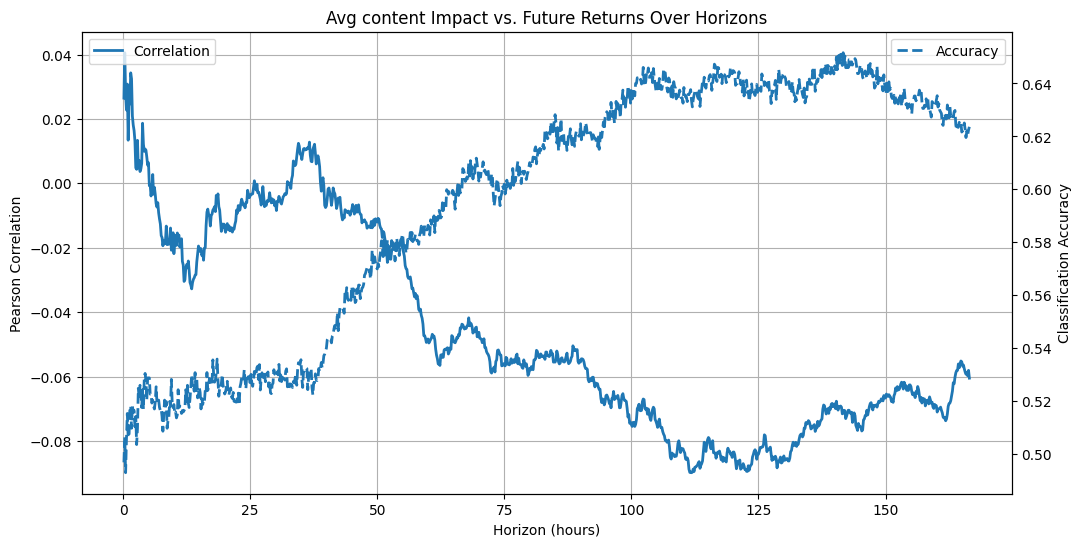

▶ Highest correlation at 20 min (0.3 h): 0.0406
▶ Highest accuracy    at 8500 min (141.7 h): 0.6516


In [ ]:
# Example usage:
horizons = np.arange(10, 10000, 10)
find_plot_metrics_by_hour(
    horizons,
    sentiment_df=btc_crypto_sentiment,
    df_ohlcv=df_ohlcv,
    impact_col_name='content_impact',
    impact_name='content'
)

In [ ]:
for source in top20_sources:
    find_plot_metrics_by_hour(
        horizons,
        btc_crypto_sentiment[btc_crypto_sentiment['sourceName'] == source],
        df_ohlcv,
        "content_impact",
        source + " content")